In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from geomloss import SamplesLoss
from torch.autograd import Function
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.functional import normalize
#from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryF1Score
torch.manual_seed(0)

In [35]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [36]:
def get_data(data_type,file_num):

    if(data_type=='train'):
        data=pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_train_{file_num}.csv")
    else:
        data = pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_test_{file_num}.csv")

    x_data=pd.concat([data.iloc[:,0], data.iloc[:, 1:30]], axis = 1)
    #x_data=data.iloc[:, 5:30]
    y_data=data.iloc[:, 1]
    return x_data,y_data

In [37]:
def get_dataloader(x_data,y_data,batch_size):

    x_train_sr=x_data[x_data['treatment']==0]
    y_train_sr=y_data[x_data['treatment']==0]
    x_train_tr=x_data[x_data['treatment']==1]
    y_train_tr=y_data[x_data['treatment']==1]


    train_data_sr = Data(np.array(x_train_sr), np.array(y_train_sr))
    train_dataloader_sr = DataLoader(dataset=train_data_sr, batch_size=batch_size)

    train_data_tr = Data(np.array(x_train_tr), np.array(y_train_tr))
    train_dataloader_tr = DataLoader(dataset=train_data_tr, batch_size=batch_size)


    return train_dataloader_sr, train_dataloader_tr

In [38]:
def pehe_loss_2(y1_pred,y0_pred,mu_1,mu_0):
    a=((mu_1-mu_0)-(y1_pred-y0_pred))
    er1=torch.square(a)
    #pehe=torch.mean(er1)
    pehe=torch.sqrt(torch.mean(er1))
    return pehe

In [39]:
input_dim=200
hidden_layers=50
output_dim=2
epochs=200
batch_size=8

In [40]:

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.linear1 = nn.Linear(200, 50)
    self.linear2 = nn.Linear(50, 2)
   
    
  def forward(self, x, alpha):
    x = ReverseLayerF.apply(x, alpha)
    x = torch.sigmoid(self.linear1(x))
    x = self.linear2(x)
    return x

class Extractor(nn.Module): # check output features...
    def __init__(self):
        super(Extractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Linear(in_features=25, out_features=200),
            nn.Linear(in_features=200, out_features=200),
            #nn.Linear(in_features=200, out_features=200),
            nn.ELU()
            #nn.ReLU()
            #nn.Linear(in_features=100, out_features=100)
            #nn.Linear(in_features=100, out_features=100)
            #nn.Linear(in_features=100, out_features=100),
            #nn.Linear(in_features=100, out_features=100)
        )

    def forward(self, x):
        x = self.extractor(x)
        #x = x.view(-1, 3 * 28 * 28)
        return x
    

    
    
class Regressor0(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(26,100)
    self.layer2 = nn.Linear(100,80)
    self.layer3 = nn.Linear(80,25)
    self.layer4 = nn.Linear(25,1)

    self.act1 = nn.ReLU()


  def forward(self, x):

    x = self.layer1(x)
    x = self.act1(x)
    x = self.layer2(x)
    x = self.act1(x)
    x = self.layer3(x)
    x = self.act1(x)
    x = self.layer4(x)

    return x

class Regressor1(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(26,100)
    self.layer2 = nn.Linear(100,80)
    self.layer3 = nn.Linear(80,25)
    self.layer4 = nn.Linear(25,1)

    self.act1 = nn.ReLU()


  def forward(self, x):

    x = self.layer1(x)
    x = self.act1(x)
    x = self.layer2(x)
    x = self.act1(x)
    x = self.layer3(x)
    x = self.act1(x)
    x = self.layer4(x)

    return x

In [41]:
domain_descr = Discriminator()
regressor0=Regressor0()
regressor1=Regressor1()
extractor=Extractor()
criterion = nn.CrossEntropyLoss()
criterion_reg=nn.MSELoss()

In [42]:
# PEHE Evaluation 

def pehe_eval(i):
    
    x_data,y_data=get_data('test',i)
    mu_data=x_data.iloc[:,3:5].to_numpy()
    mu_data=torch.from_numpy(mu_data.astype(np.float32))

    test_data=x_data.iloc[:,5:30].to_numpy()
    test_data=torch.from_numpy(test_data.astype(np.float32))
    #encoded_test=extractor(test_data)

    s_zeros_t=torch.zeros(test_data.shape[0],1)
    t_ones_t=torch.ones(test_data.shape[0],1)

    data_zeros=torch.cat((s_zeros_t,test_data),1)           
    data_ones=torch.cat((t_ones_t,test_data),1)


    y0=regressor0(data_zeros)
    y1=regressor1(data_ones)


    pehe=pehe_loss_2(y1,y0,mu_data[:,1],mu_data[:,0])
    
    return pehe

#with torch.no_grad():

#print('Accuracy: ',100 * correct // total )

In [43]:
pehe_lo = []
domain_lo=[]
s_reg_lo=[]
t_reg_lo=[]
d_accu=[]
metric=BinaryF1Score()
num_files=101
for nf in range(1,num_files):
    x_data,y_data=get_data('train',nf)
    correct, total = 0, 0

    #optimizer3 = optim.SGD(Network.parameters(),lr=0.001,momentum=1e-8)
    opt_dis = torch.optim.SGD(domain_descr.parameters(), lr=0.1)
    opt_reg0= torch.optim.SGD(regressor0.parameters(), lr=0.01)
    opt_reg1= torch.optim.SGD(regressor1.parameters(), lr=0.01)
    opt_ext= torch.optim.SGD(extractor.parameters(), lr=0.01)

    for ep in range(1,epochs+1 ):
        lamda_max=5
        e0=10
        s_reg=0
        t_reg=0
        dl=0
        peh=0
        dom_loss = 0
        reg_s_loss=0
        reg_t_loss=0
        train_dataloader_sr, train_dataloader_tr=get_dataloader(x_data,y_data,batch_size)
        lambda_val=(lamda_max)*((ep-e0)/(epochs-e0))
        alpha=max(0,lambda_val)
        for batch_idx, (train_source_data, train_target_data) in enumerate(zip(train_dataloader_sr, train_dataloader_tr)):
            xs,ys=train_source_data
            xt,yt=train_target_data
            xs_train=xs[:,5:30]
            xt_train=xt[:,5:30]
            
            #encoding on both domains
            encoded_source=extractor(xs_train)
            encoded_target=extractor(xt_train)
            
            
            #Adding treatment to encoded space
            s_zeros=torch.zeros(xs_train.shape[0],1)
            t_ones=torch.ones(xt_train.shape[0],1)
            
            xs_train=torch.cat((s_zeros,xs_train),1)
            xt_train=torch.cat((t_ones,xt_train),1)
           
            
            
            # preprocessing before feeding to decriminator
            inputs_discr=torch.cat((encoded_source,encoded_target),0)
            labels_discr=torch.cat((xs[:,0].type(torch.LongTensor),xt[:,0].type(torch.LongTensor)),0)
            
            # individual predictions for all networks
            #outputs_discr = domain_descr(inputs_discr,alpha)
            source_preds=regressor0(xs_train)
            target_preds=regressor1(xt_train)
            
            
            
            # set optimizer to zero grad to remove previous epoch gradients
            #opt_dis.zero_grad()
            opt_reg0.zero_grad()
            opt_reg1.zero_grad()
            #opt_ext.zero_grad()

            #individual loss for all networks
       
            #disc_entr = criterion(outputs_discr, labels_discr)
            source_mse=criterion_reg(source_preds,ys)
            target_mse=criterion_reg(target_preds,yt)
            
            #combined loss
            combined_loss=source_mse+target_mse
            
            # backward propagation
            combined_loss.backward()
            # optimize
            #opt_dis.step()
            opt_reg0.step()
            opt_reg1.step()
            #opt_ext.step()
            #loss per batch on training
            #dom_loss += disc_entr.item()
            reg_s_loss+=source_mse.item()
            reg_t_loss+=target_mse.item()
            #Accuracy per batch on training
            
            # get the predictions
            #__, predicted = torch.max(outputs_discr.data, 1)
            # update results
            #total += labels_discr.size(0)
            #correct += (predicted == labels_discr).sum().item()

          # display statistics
        #domain_lo.append(dom_loss)
        s_reg_lo.append(reg_s_loss)
        t_reg_lo.append(reg_t_loss)
        #d_accu.append(100 * correct // total )
    pehe=pehe_eval(nf)
    pehe_lo.append(pehe.item())
        #print(f'[{ep + 1}, {batch_idx + 1:5d}] loss: {dom_loss}')
        
        #print('alpha',alpha)

/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ahmad/envs/RL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

In [45]:
print(pehe_lo)

[1.5124707221984863, 1.5506174564361572, 1.6587804555892944, 0.9430019855499268, 1.43169367313385, 4.254352569580078, 0.5564850568771362, 0.8089462518692017, 2.451836585998535, 3.5011343955993652, 2.2217888832092285, 0.5337474942207336, 0.6547759175300598, 3.0053563117980957, 4.483577728271484, 1.6535210609436035, 0.6275758147239685, 0.5085594058036804, 2.2174012660980225, 3.170893669128418, 2.3173975944519043, 0.9125697016716003, 0.907898485660553, 1.0870403051376343, 0.7251766324043274, 1.5246241092681885, 1.9444373846054077, 1.7625806331634521, 5.5359110832214355, 0.7992801070213318, 0.66452956199646, 0.6793230175971985, 0.7826238870620728, 1.1591426134109497, 0.917914092540741, 0.8718408942222595, 0.8222399353981018, 0.6745069622993469, 2.234870672225952, 8.5145263671875, 3.715261459350586, 0.8795837759971619, 0.8184130787849426, 3.4747090339660645, 0.5734411478042603, 0.8873730897903442, 1.4473152160644531, 4.028963565826416, 6.4858808517456055, 7.529144763946533, 2.42247414588928

In [46]:
print(np.mean(pehe_lo))

2.3349800261855127


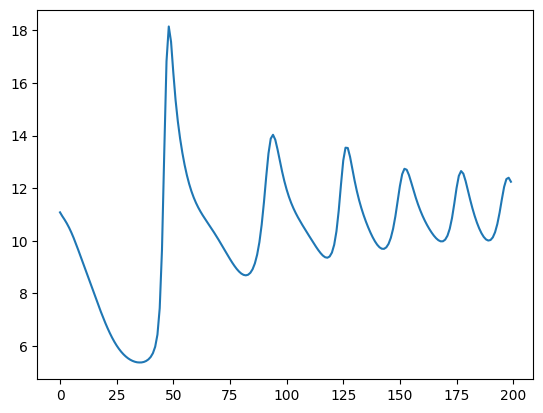

In [56]:
plt.plot(domain_lo)
plt.show()

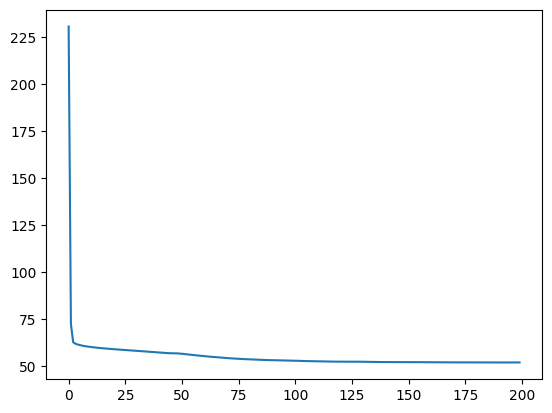

In [57]:
plt.plot(s_reg_lo)
plt.show()

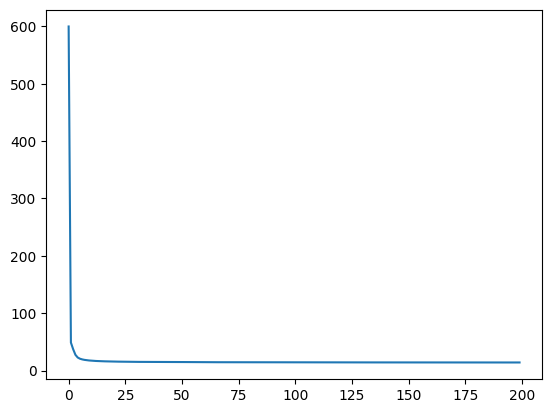

In [58]:
plt.plot(t_reg_lo)
plt.show()

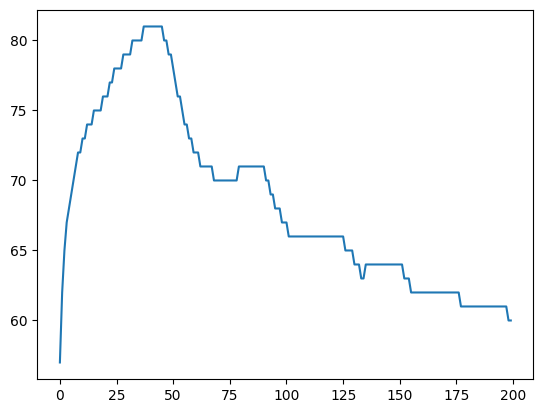

In [59]:
plt.plot(d_accu)
plt.show()

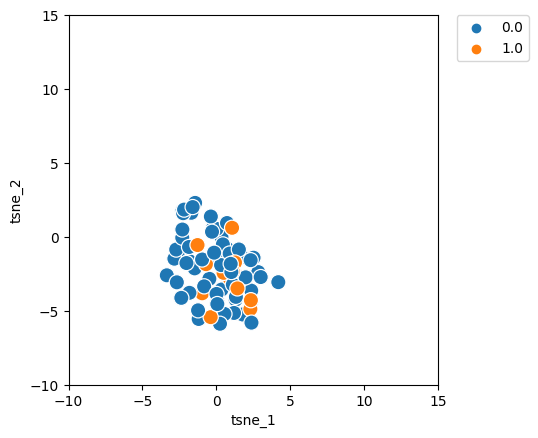

In [60]:
file_num=1
x_data,y_data=get_data('test',file_num)
mu_data=x_data.iloc[:,3:5].to_numpy()
mu_data=torch.from_numpy(mu_data.astype(np.float32))

test_data=x_data.iloc[:,5:30].to_numpy()
test_data=torch.from_numpy(test_data.astype(np.float32))
test_y=x_data.iloc[:,0].to_numpy()
test_y=torch.from_numpy(test_y.astype(np.float32))
encoded_test=extractor(test_data)
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components,random_state=0)
tsne_result = tsne.fit_transform(test_data.detach().cpu().numpy()) #combined_features combined_transformed

# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': test_y.detach().cpu().numpy()})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
#lim = (tsne_result.min()-5, tsne_result.max()+5)
lim = (-10, 15)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

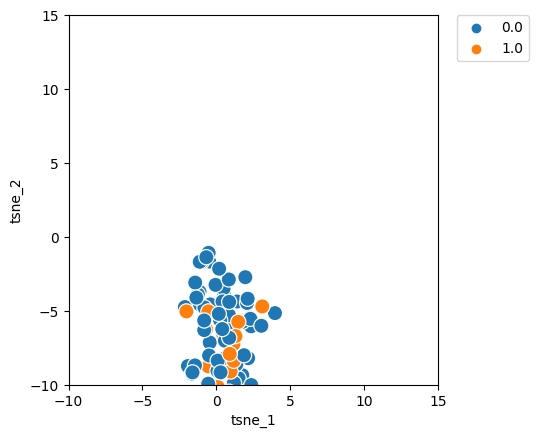

In [61]:
x_data,y_data=get_data('test',file_num)
mu_data=x_data.iloc[:,3:5].to_numpy()
mu_data=torch.from_numpy(mu_data.astype(np.float32))

test_data=x_data.iloc[:,5:30].to_numpy()
test_data=torch.from_numpy(test_data.astype(np.float32))
test_y=x_data.iloc[:,0].to_numpy()
test_y=torch.from_numpy(test_y.astype(np.float32))
encoded_test=extractor(test_data)
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components,random_state=0)
tsne_result = tsne.fit_transform(encoded_test.detach().cpu().numpy()) #combined_features combined_transformed

# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': test_y.detach().cpu().numpy()})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
#lim = (tsne_result.min()-5, tsne_result.max()+5)
lim = (-10, 15)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)